In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Replace with local path or URL
data = pd.read_csv("household_power_consumption.txt", sep=';', 
                   parse_dates={'Datetime':['Date','Time']}, 
                   infer_datetime_format=True, 
                   low_memory=False, 
                   na_values=['?'])

data.head()


C:\Users\User\AppData\Local\Temp\ipykernel_4356\2759510024.py:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  data = pd.read_csv("household_power_consumption.txt", sep=';',
C:\Users\User\AppData\Local\Temp\ipykernel_4356\2759510024.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv("household_power_consumption.txt", sep=';',
C:\Users\User\AppData\Local\Temp\ipykernel_4356\2759510024.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv("household_power_consumption.txt", sep=';',


,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [3]:
# Convert target to numeric
data['Global_active_power'] = pd.to_numeric(data['Global_active_power'], errors='coerce')

# Fill missing with forward fill
data['Global_active_power'].fillna(method='ffill', inplace=True)

# Check missing values
data.isnull().sum()


C:\Users\User\AppData\Local\Temp\ipykernel_4356\4118950993.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Global_active_power'].fillna(method='ffill', inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_4356\4118950993.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Global_active_power'].fillna(method='ffill', inplace=True)


Datetime                     0
Global_active_power          0
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [4]:
ts = data.set_index('Datetime')['Global_active_power'].resample('H').mean()
ts.head()


C:\Users\User\AppData\Local\Temp\ipykernel_4356\605804252.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = data.set_index('Datetime')['Global_active_power'].resample('H').mean()


Datetime
2006-12-16 17:00:00    4.222889
2006-12-16 18:00:00    3.632200
2006-12-16 19:00:00    3.400233
2006-12-16 20:00:00    3.268567
2006-12-16 21:00:00    3.056467
Freq: h, Name: Global_active_power, dtype: float64

In [5]:
df = ts.reset_index()
df['hour'] = df['Datetime'].dt.hour
df['dayofweek'] = df['Datetime'].dt.dayofweek
df['month'] = df['Datetime'].dt.month
df['weekday'] = df['Datetime'].dt.weekday < 5


In [6]:
train_size = int(len(df) * 0.9)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

print(train.shape, test.shape)


(31130, 6) (3459, 6)


In [7]:
# Use auto_arima to find best parameters
arima_model = pm.auto_arima(train['Global_active_power'], seasonal=False, stepwise=True)
arima_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                31130
Model:               SARIMAX(1, 1, 3)   Log Likelihood              -29706.585
Date:                Sat, 17 Jan 2026   AIC                          59425.171
Time:                        11:14:52   BIC                          59475.246
Sample:                             0   HQIC                         59441.210
                              - 31130                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.171e-05   8.84e-05     -0.246      0.806      -0.000       0.000
ar.L1          0.5124      0.011     46.643      0.000       0.491       0.534
ma.L1         -0.7507      0.012    -63.769      0.000      -0.774      -0.728
ma.L2         -0.1487      0.007    -22.689      0.000      -0.162      -0.136
ma.L3         -0.0815      0.008     -9.974      0.000      -0.097      -0.065
sigma2         0.3948      0.002    166.361      0.000       0.390       0.399
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):             19514.99
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             1.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
n_periods = len(test)
arima_forecast = arima_model.predict(n_periods=n_periods)

# Evaluate
mae_arima = mean_absolute_error(test['Global_active_power'], arima_forecast)
rmse_arima = np.sqrt(mean_squared_error(test['Global_active_power'], arima_forecast))
print("ARIMA - MAE:", mae_arima, "RMSE:", rmse_arima)


ARIMA - MAE: 0.5573947773742937 RMSE: 0.7483250006815103


In [9]:
prophet_df = train[['Datetime','Global_active_power']].rename(columns={'Datetime':'ds','Global_active_power':'y'})
prophet_model = Prophet(daily_seasonality=True, weekly_seasonality=True)
prophet_model.fit(prophet_df)

future = prophet_model.make_future_dataframe(periods=len(test), freq='H')
forecast = prophet_model.predict(future)

# Extract forecast
prophet_forecast = forecast['yhat'].iloc[-len(test):].values

# Evaluate
mae_prophet = mean_absolute_error(test['Global_active_power'], prophet_forecast)
rmse_prophet = np.sqrt(mean_squared_error(test['Global_active_power'], prophet_forecast))
print("Prophet - MAE:", mae_prophet, "RMSE:", rmse_prophet)


11:15:01 - cmdstanpy - INFO - Chain [1] start processing
11:15:31 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


Prophet - MAE: 0.5041273281422731 RMSE: 0.6509286503755037


In [10]:
features = ['hour', 'dayofweek', 'month', 'weekday']

X_train = train[features]
y_train = train['Global_active_power']

X_test = test[features]
y_test = test['Global_active_power']

# Standard scaling (optional)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


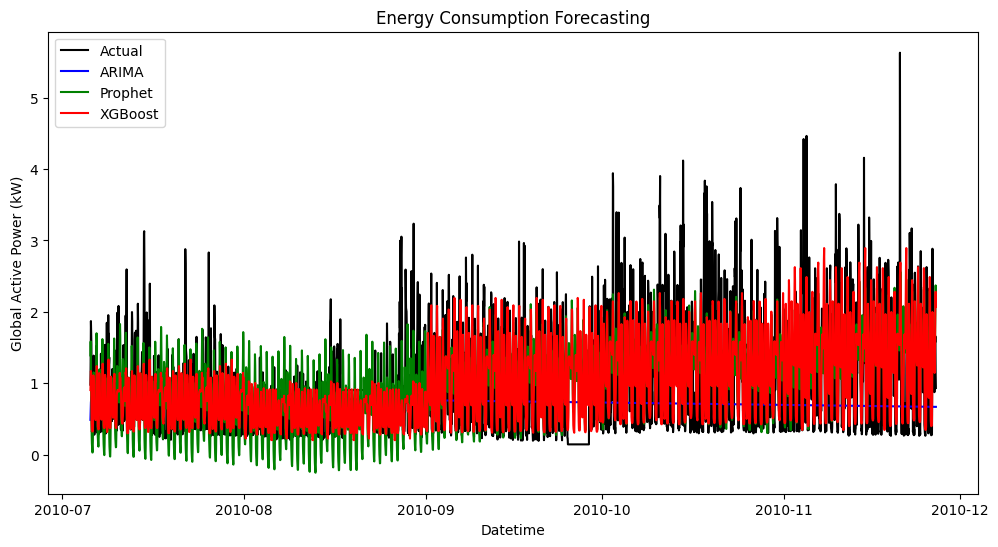

In [13]:
# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Generate predictions
xgb_forecast = xgb_model.predict(X_test_scaled)

# Plot the results
plt.figure(figsize=(12,6))
plt.plot(test['Datetime'], y_test, label='Actual', color='black')
plt.plot(test['Datetime'], arima_forecast, label='ARIMA', color='blue')
plt.plot(test['Datetime'], prophet_forecast, label='Prophet', color='green')
plt.plot(test['Datetime'], xgb_forecast, label='XGBoost', color='red')
plt.xlabel("Datetime")
plt.ylabel("Global Active Power (kW)")
plt.title("Energy Consumption Forecasting")
plt.legend()
plt.show()


In [ ]:
# Calculate MAE and RMSE for XGBoost
mae_xgb = mean_absolute_error(y_test, xgb_forecast)
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_forecast))

# Create results DataFrame
results = pd.DataFrame({
    'Model':['ARIMA','Prophet','XGBoost'],
    'MAE':[mae_arima, mae_prophet, mae_xgb],
    'RMSE':[rmse_arima, rmse_prophet, rmse_xgb]
})

results 


,Model,MAE,RMSE
0,ARIMA,0.557395,0.748325
1,Prophet,0.504127,0.650929
2,XGBoost,0.428987,0.599916
